## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from joblib import dump, load

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [26]:
sample_size = 100_000
data = pd.read_csv("../data/ceidg_data_classif.csv").sample(sample_size)
print(data.shape)

x_train, x_test, y_train, y_test = train_test_split(data.drop("Target", axis=1), data["Target"], random_state=RANDOM_SEED)
x_train.head()

(100000, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,HasPolishCitizenship,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses
1100039,2018-04-01,December,4,WIELKOPOLSKIE,RAWICKI,3022035.0,WIELKOPOLSKIE,RAWICKI,3022035.0,True,...,True,False,C,33.0,331.0,3312.0,4,6,8,9
22541,2018-06-07,February,1,MAZOWIECKIE,WARSZAWA,1465158.0,MAZOWIECKIE,WARSZAWA,1465158.0,True,...,True,False,P,85.0,855.0,8553.0,1,1,1,1
1670697,2018-04-01,January,1,PODKARPACKIE,STRZYżOWSKI,1819044.0,NaN,NaN,NaN,False,...,True,False,G,45.0,452.0,4520.0,1,1,1,1
430173,2018-08-23,May,2,WARMIŃSKO-MAZURSKIE,ELBLąG,2861011.0,WARMIŃSKO-MAZURSKIE,ELBLąG,2861011.0,True,...,True,False,Q,86.0,869.0,8690.0,1,1,1,1
231336,2018-04-21,September,3,LUBELSKIE,BIALSKI,601102.0,LUBELSKIE,BIALSKI,601102.0,True,...,True,False,G,47.0,475.0,4752.0,6,9,15,16


List of features with explanation:

- **RandomDate**: Randomly chose date beetween 01-11-2017 and 01-11-2018 (or date of termination or suspension if continuity of the Business were stopped earlier in this period).
- **Target**: The binary response variable indicates if continuity of the business was broken in **12 months from random date**. 
- **MonthOfStartingOfTheBusiness**: The month of registering a business in the CEIDG registry.
- **QuarterOfStartingOfTheBusiness**: The quarter of registering a business in the CEIDG registry.
- **MainAddressVoivodeship**.
- **MainAddressCounty**.
- **MainAddressTERC: Helper column.** [TERC Code](https://pl.wikipedia.org/wiki/TERC). May be used for data enhacement form other data sources (eg. GUS BDL via **[R_Package_to_API_BDL](https://github.com/statisticspoland/R_Package_to_API_BDL)**).
- **CorrespondenceAddressVoivodeship**.
- **CorrespondenceAddressCounty**.
- **CorrespondenceAddressTERC: Helper column.** [TERC Code](https://pl.wikipedia.org/wiki/TERC). May be used for data enhacement form other data sources (eg. GUS BDL via **[R_Package_to_API_BDL](https://github.com/statisticspoland/R_Package_to_API_BDL)**). 
- **MainAndCorrespondenceAreTheSame**: Checking if the correspondence address and the main address are the same (with an accuracy to the street).
- **DurationOfExistenceInMonths**: Time in months from registering of the business to **RandomDate** (results has been rounded down to the nearest integer). 
- **NoOfAdditionalPlaceOfTheBusiness**.
- **IsPhoneNo**: Checking if the phone number has been filled in the register (filling in the field is optional).
- **IsEmail**: Checking if the email has been filled in the register (filling in the field is optional).
- **IsWWW**: Checking if the web address has been filled in the register (filling in the field is optional).
- **CommunityProperty**: 
- **HasLicences**: Checking if the business is running with special permissions (eg. sale of alcohol, transportation of people).
- **NoOfLicences**.
- **Sex**: Variable has been created by checking the last letter of a name. If the last letter is 'a' then sex is defined as female, otherwise as male. The disadvantage of this approach is the possibility of not classifying foreigners correctly.
- **HasPolishCitizenship**.
- **ShareholderInOtherCompanies**.

Features listed below based on [Polska Klasyfikacja Działalności](https://www.biznes.gov.pl/en/classification-pkd-code)

- **PKDMainSection**.
- **PKDMainDivision**.
- **PKDMainGroup**.
- **PKDMainClass**.
- **NoOfUniquePKDSections**.
- **NoOfUniquePKDDivsions**.
- **NoOfUniquePKDGroups**.
- **NoOfUniquePKDClasses**.

---
### Data exploration

In [27]:
print("Percentage of companies that failed after 12 months: {:.2f}%".format(y_train.mean()*100))

Percentage of companies that failed after 12 months: 17.48%


In [28]:
data.columns

Index(['RandomDate', 'MonthOfStartingOfTheBusiness',
       'QuarterOfStartingOfTheBusiness', 'MainAddressVoivodeship',
       'MainAddressCounty', 'MainAddressTERC',
       'CorrespondenceAddressVoivodeship', 'CorrespondenceAddressCounty',
       'CorrespondenceAddressTERC', 'MainAndCorrespondenceAreTheSame',
       'DurationOfExistenceInMonths', 'NoOfAdditionalPlaceOfTheBusiness',
       'IsPhoneNo', 'IsEmail', 'IsWWW', 'CommunityProperty', 'HasLicences',
       'NoOfLicences', 'Sex', 'HasPolishCitizenship',
       'ShareholderInOtherCompanies', 'PKDMainSection', 'PKDMainDivision',
       'PKDMainGroup', 'PKDMainClass', 'NoOfUniquePKDSections',
       'NoOfUniquePKDDivsions', 'NoOfUniquePKDGroups', 'NoOfUniquePKDClasses',
       'Target'],
      dtype='object')

In [29]:
data["CommunityProperty"]  # some NANs that are represented as '-'

290337     nie
491136     tak
2386061    tak
640960     nie
1993703      -
          ... 
480993     tak
859577       -
359853     nie
2398222    tak
1467041    tak
Name: CommunityProperty, Length: 100000, dtype: object

#### Missing values
Strategy: fill NAs with "unkown" value for categorial variables. Numerical and boolean variables don't have NAs.

In [30]:
data.isna().mean()

RandomDate                          0.00000
MonthOfStartingOfTheBusiness        0.00000
QuarterOfStartingOfTheBusiness      0.00000
MainAddressVoivodeship              0.02908
MainAddressCounty                   0.02911
MainAddressTERC                     0.02989
CorrespondenceAddressVoivodeship    0.05705
CorrespondenceAddressCounty         0.05789
CorrespondenceAddressTERC           0.07653
MainAndCorrespondenceAreTheSame     0.00000
DurationOfExistenceInMonths         0.00000
NoOfAdditionalPlaceOfTheBusiness    0.00000
IsPhoneNo                           0.00000
IsEmail                             0.00000
IsWWW                               0.00000
CommunityProperty                   0.00000
HasLicences                         0.00000
NoOfLicences                        0.00000
Sex                                 0.00000
HasPolishCitizenship                0.00000
ShareholderInOtherCompanies         0.00000
PKDMainSection                      0.01480
PKDMainDivision                 

#### Types of columns

In [31]:
data.dtypes

RandomDate                           object
MonthOfStartingOfTheBusiness         object
QuarterOfStartingOfTheBusiness        int64
MainAddressVoivodeship               object
MainAddressCounty                    object
MainAddressTERC                     float64
CorrespondenceAddressVoivodeship     object
CorrespondenceAddressCounty          object
CorrespondenceAddressTERC           float64
MainAndCorrespondenceAreTheSame        bool
DurationOfExistenceInMonths           int64
NoOfAdditionalPlaceOfTheBusiness      int64
IsPhoneNo                              bool
IsEmail                                bool
IsWWW                                  bool
CommunityProperty                    object
HasLicences                            bool
NoOfLicences                          int64
Sex                                  object
HasPolishCitizenship                   bool
ShareholderInOtherCompanies            bool
PKDMainSection                       object
PKDMainDivision                 

In [32]:
categorical_variables = ["MonthOfStartingOfTheBusiness", "MainAddressVoivodeship", "PKDMainSection",  "Sex"]
numerical_variables = [
    "MainAndCorrespondenceAreTheSame", 
    "DurationOfExistenceInMonths", 
    "NoOfAdditionalPlaceOfTheBusiness",
    "IsPhoneNo",
    "IsEmail",
    "IsWWW",
#     "HasLicences",  # useless since we have NoOfLicenses
    "NoOfLicences",
    "HasPolishCitizenship",
    "ShareholderInOtherCompanies"
]

impute_encode = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("one_hot_enocde", OneHotEncoder(handle_unknown="ignore"))
])

scale = Pipeline([
    ("min_max_scale", MinMaxScaler())
])

column_transformer = ColumnTransformer([
    ("one_hot_encoder", impute_encode , categorical_variables),
    ("numerical_variables", scale, numerical_variables)
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("classifier", LogisticRegression(max_iter=1000, tol=1e-4, C=100))
])

In [33]:
pipeline.fit(x_train, y_train);

Accuracy: 82.28
F-1 score: 0.0000


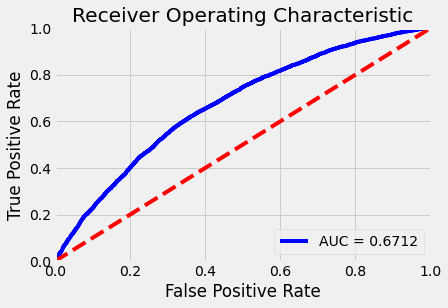

0.6711591392455708

In [34]:
evaluate(pipeline, x_test, y_test)

---
#### What features are important?

In [11]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name != 'remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i, 'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

In [12]:
feature_names = get_transformer_feature_names(pipeline["get_features"]);
feature_scores = pipeline["classifier"].coef_[0]

In [13]:
top = 15
name_score = list(zip(feature_names, feature_scores))
name_score.sort(key=lambda t: abs(t[1]), reverse=True)
top_name_scores = name_score[:top]
top_names, top_scores = zip(*top_name_scores)

In [14]:
top_name_scores

[('NoOfLicences', -46.08158318531363),
 ('NoOfAdditionalPlaceOfTheBusiness', -37.29573160227897),
 ('MainAddressVoivodeship_ŚWIęTOKRZYSKIE', -2.580859184501486),
 ('MainAddressVoivodeship_ŚLąSKIE', -2.2193619002631992),
 ('DurationOfExistenceInMonths', -1.329404180706867),
 ('ShareholderInOtherCompanies', -1.0365881626450102),
 ('PKDMainSection_Q', -0.8481276740351659),
 ('MainAddressVoivodeship_ŚWIETORZYSKIE', -0.8202613127606648),
 ('PKDMainSection_J', -0.6358491780141478),
 ('PKDMainSection_E', 0.5970174564798026),
 ('Sex_M', -0.5455513703251268),
 ('MainAddressVoivodeship_WARMIńSKO-MAZURSKIE', 0.5362510374327996),
 ('PKDMainSection_B', 0.47302999069223906),
 ('PKDMainSection_S', -0.43323671570215105),
 ('PKDMainSection_M', -0.4092187912587819)]

<BarContainer object of 15 artists>

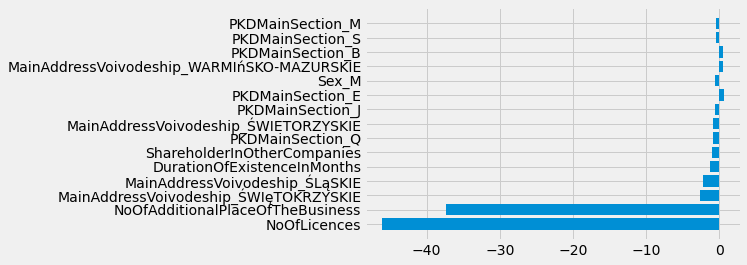

In [15]:
f, ax = plt.subplots()
plt.barh(np.arange(len(top_names)), top_scores, tick_label=top_names)

---
#### Saving pipeline and predictions

In [16]:
dump(pipeline, '../models/lr.joblib')

['../models/lr.joblib']

In [17]:
predicted_target = pipeline.predict(x_test)
predicted_proba = pipeline.predict_proba(x_test)[:, 1]

In [18]:
x_test["PredictedTarget"] = predicted_target
x_test["PredictedProba"] = predicted_proba
x_test["Target"] = y_test
x_test.to_csv("../models/x_test_lr.csv", index=False)

In [20]:
pd.read_csv("../models/x_test_lr.csv").head()

,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses,PredictedTarget,PredictedProba,Target
0,2018-09-20,April,2,POMORSKIE,WEJHEROWSKI,2215092.0,POMORSKIE,WEJHEROWSKI,2215092.0,True,...,23.0,237.0,2370.0,6,7,13,15,False,0.183406,False
1,2018-07-25,August,3,POMORSKIE,WEJHEROWSKI,2215092.0,POMORSKIE,WEJHEROWSKI,2215092.0,True,...,69.0,691.0,6910.0,1,2,2,2,False,0.168091,False
2,2018-03-20,April,2,ŚWIĘTOKRZYSKIE,PIńCZOWSKI,2608045.0,ŚWIĘTOKRZYSKIE,PIńCZOWSKI,2608045.0,True,...,45.0,454.0,4540.0,1,1,1,1,False,0.330060,False
3,2018-07-22,December,4,ZACHODNIOPOMORSKIE,ŚWINOUJśCIE,3263011.0,NaN,NaN,NaN,False,...,68.0,681.0,6810.0,1,1,1,1,False,0.077544,True
4,2018-09-15,May,2,MAŁOPOLSKIE,LIMANOWSKI,1207011.0,MAŁOPOLSKIE,LIMANOWSKI,1207011.0,True,...,96.0,960.0,9602.0,3,3,4,6,False,0.064186,False


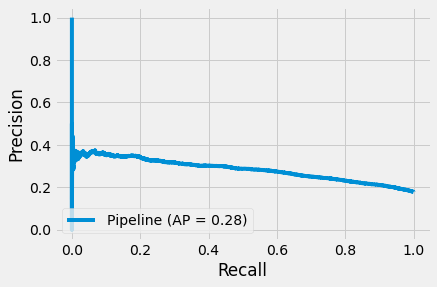

In [35]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(pipeline, x_test, y_test)